# Evaluation of multi-omics GRN inference methods
## Preprocessing multi-omics data
### by Jalil Nourisa

# Imports 

In [1]:
import os
import gzip
import pandas as pd
import numpy as np
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.cluster import KMeans
from scipy.sparse import csr_matrix


import scanpy as sc
import matplotlib.pyplot as plt
import tqdm
import scipy
import seaborn as sns
import json
import anndata as ad
import warnings
# import decoupler as dc

# from venn import venn 

import matplotlib
matplotlib.rc('font', family='serif')
matplotlib.rc('text', usetex='false')
matplotlib.rcParams.update({'font.size': 10})

work_dir = '../../output'
kaggle_data_dir = '/beegfs/desy/user/nourisaj/openproblems_sc_perturbation/input/'
# kaggle_data_dir = '../../input/kaggle/input'
T_cells = ['T regulatory cells', 'T cells CD8+', 'T cells CD4+']
def func_leiden(adata):
    adata.layers['counts'] = adata.X.copy()
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, n_top_genes=2000)
    sc.tl.pca(adata, n_comps=50, use_highly_variable=True)
    sc.pp.neighbors(adata, n_pcs=30)
    sc.tl.umap(adata)
    sc.tl.leiden(adata)
def plot_umap(adata_o, color='leiden', ax=None, groups=None):
    adata = adata_o.copy()
    if groups is not None:
        adata.obs[color] = adata.obs[color].astype(str)
        mask = adata.obs[color].isin(groups)
        print(mask.sum())
        adata.obs.loc[~mask, color] = 'background'
    #     adata.obs['color'] = adata.obs['color'].astype(str).astype(categorical)
        
    x_data = adata.obsm['X_umap'][:,0]
    y_data = adata.obsm['X_umap'][:,1]
    xlim = [min(x_data)+.1*min(x_data), max(x_data)+.1*max(x_data)]
    ylim = [min(y_data)+.1*min(y_data), max(y_data)+.1*max(y_data)]
    if isinstance(adata.obs[color].iloc[0], (int, float)):
        # Continuous variable
        scatter = ax.scatter(x_data, y_data, c=adata.obs[color], cmap='viridis', alpha=0.3, s=1)
        plt.colorbar(scatter, ax=ax)
    else:
        unique_colors = adata.obs[color].unique()
        num_colors = len(unique_colors)
        if num_colors > 10:
            cmap = plt.get_cmap('tab20')  # Use a color map with more distinct colors
            color_list = cmap(np.linspace(0, 1, num_colors))
            color_list = [list(color_list[i]) for i in range(num_colors)]  # Convert each color to list format

        else:
            color_list = None  # Use default color map if fewer than 10 colors
            
        for i, c in enumerate(unique_colors):
            mask = adata.obs[color]==c
            if c == 'background':
                ax.scatter(x_data[mask], y_data[mask], s=.5, label=c, color='lightgrey', alpha=.01)
            else:
                ax.scatter(x_data[mask], y_data[mask], s=1, label=c, color=color_list[i] if color_list else None, alpha=.3)
            if color == 'leiden':
                avg_x = np.mean(x_data[mask])
                avg_y = np.mean(y_data[mask])
                ax.annotate(c, (avg_x, avg_y),ha='center', fontsize=15)

    ax.set_xlabel('UMAP1')
    ax.set_ylabel('UMAP2')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xticks([])
    ax.set_yticks([])

    if color!='leiden':
        legend = ax.legend(loc='upper left', bbox_to_anchor=(1,1), frameon=False)
        # legend = ax.legend()
        for handle in legend.legendHandles:
            handle.set_sizes([50])
    ax.set_title(color)
def plot_umap_group(adata, colors):
    n = len(colors)
    fig, axes = plt.subplots(1, n, figsize=(6*n, 4))
    for ii, color in enumerate(colors):
        plot_umap(adata, color=color, ax=axes[ii])
    plt.tight_layout()
    return fig


In [3]:
multiome_var_meta = pd.read_csv(f'{kaggle_data_dir}/open-problems-single-cell-perturbations/multiome_var_meta.csv')
multiome_train = pd.read_parquet(f'{kaggle_data_dir}/open-problems-single-cell-perturbations/multiome_train.parquet')
multiome_obs_meta = pd.read_csv(f'{kaggle_data_dir}/open-problems-single-cell-perturbations/multiome_obs_meta.csv')

# scRNA-seq
We use provided normalized values as X and store the counts in the layers.

## Formatize the data

In [4]:

genes_locations = multiome_var_meta[multiome_var_meta['feature_type']=='Gene Expression']['location'].values
df_mrna = multiome_train[multiome_train['location'].isin(genes_locations)].reset_index(drop=True)
# get count and normalized count
df_mrna_pivot_raw = df_mrna.pivot(index='obs_id', columns='location', values='count')
df_mrna_pivot_raw = df_mrna_pivot_raw.fillna(0)
mrna_sparse_raw = csr_matrix(df_mrna_pivot_raw.values)
# df_mrna_pivot_n = df_mrna.pivot(index='obs_id', columns='location', values='normalized_count')
# df_mrna_pivot_n = df_mrna_pivot_n.fillna(0)
# mrna_sparse_n = csr_matrix(df_mrna_pivot_n.values)

In [7]:
adata_rna = ad.AnnData(X=mrna_sparse_raw, 
                obs=multiome_obs_meta.set_index('obs_id'),
                var=pd.DataFrame(index=df_mrna_pivot_raw.columns)
                )
adata_rna.shape

(25551, 22787)

## QS

In [2]:
adata_rna = ad.read(f'{work_dir}/scRNA/adata_rna.h5ad')

/root/anaconda3/envs/py10/lib/python3.10/site-packages/anndata/__init__.py:55: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [4]:
import sctk
sctk.calculate_qc(adata_rna, flags={"mito": r"^MT-", "ribo": r"^RP[LS]"})
# sctk.calculate_qc(adata_rna)
sctk.cellwise_qc(adata_rna)

/root/.local/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


n_counts: [1000.0000463230983, 19978.994140625], 25547/25547 passed
n_genes: [691.1768837674327, 5745.001953125], 25429/25547 passed
percent_mito: [0.0, 15.571746011893392], 25402/25547 passed
percent_ribo: [0.8829415259221228, 16.21716400235061], 25201/25547 passed
25034/25547 pass


In [8]:
25547 - 25034

513

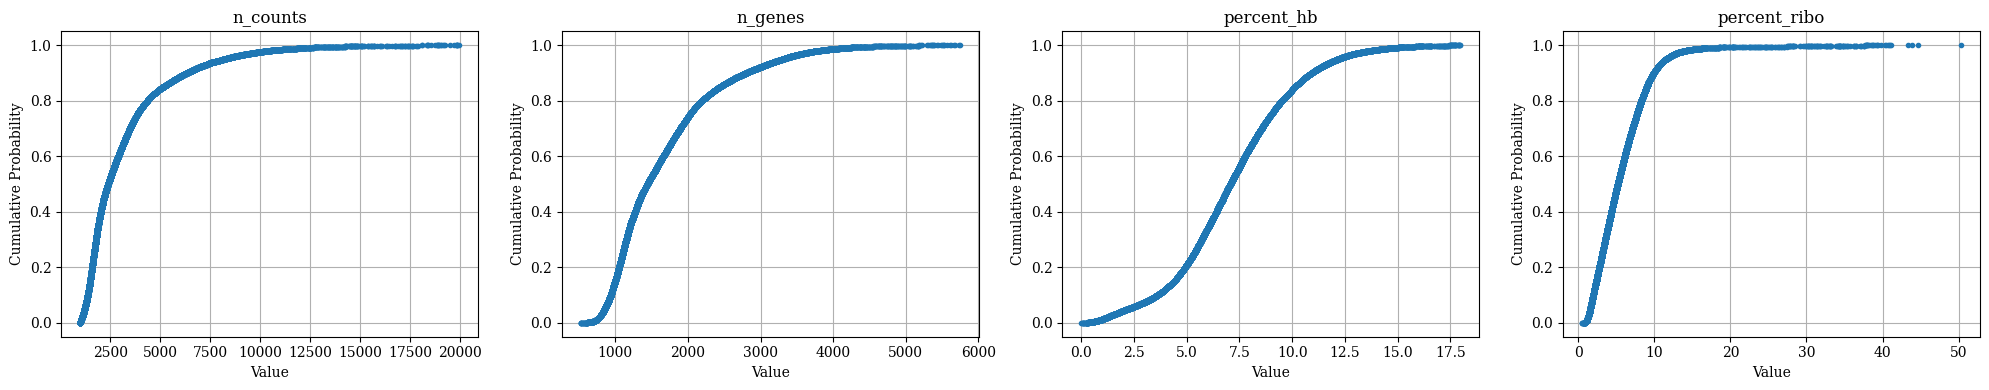

In [7]:
fig, axes = plt.subplots(1, 4, figsize=(20,4))
def plot_CDF(data, title, ax):
    x = np.sort(data)
    y = np.arange(1, len(data) + 1) / len(data)
    ax.plot(x, y, marker='.', linestyle='none')
    ax.set_xlabel('Value')
    ax.set_ylabel('Cumulative Probability')
    ax.set_title(title)
    ax.grid(True)

plot_CDF(adata_rna.obs.n_counts, 'n_counts', axes[0])
plot_CDF(adata_rna.obs.n_genes, 'n_genes', axes[1])
plot_CDF(adata_rna.obs.percent_mito, 'percent_hb', axes[2])
plot_CDF(adata_rna.obs.percent_ribo, 'percent_ribo', axes[3])
plt.tight_layout()
plt.show()

In [13]:
# apply filtering: cell weise 
adata_rna = adata_rna[adata_rna.obs.cell_passed_qc]

In [17]:
(adata_rna.X!=0).sum(axis=1).min()

692

## Save

In [25]:
adata_rna.obs = adata_rna.obs.drop(columns=['n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_top50', 'cell_passed_qc'])
adata_rna.var = adata_rna.var.drop(columns=['mito', 'ribo', 'n_counts', 'n_cells'])
del adata_rna.uns

map_names = {'donor_0':'Donor 1', 'donor_1': 'Donor 2', 'donor_2': 'Donor 3'} 
adata_rna.obs['Donor'] = adata_rna.obs.donor_id.map(map_names)
adata_rna.obs['Cell type'] = adata_rna.obs.cell_type

adata_rna.write(f'{work_dir}/scRNA/adata_rna.h5ad')

## Cell type reannotation

In [3]:
adata_rna = ad.read_h5ad(f'{work_dir}/scRNA/adata_rna.h5ad')

In [ ]:
def func_leiden(adata):
    adata.layers['counts'] = adata.X.copy()
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, n_top_genes=2000)
    sc.tl.pca(adata, n_comps=50, use_highly_variable=True)
    sc.pp.neighbors(adata, n_pcs=30)
    sc.tl.umap(adata)
    sc.tl.leiden(adata)


adata_rna_donor_1 = adata_rna[adata_rna.obs.donor_id=='donor_0', :]
adata_rna_donor_2 = adata_rna[adata_rna.obs.donor_id=='donor_1', :]
adata_rna_donor_3 = adata_rna[adata_rna.obs.donor_id=='donor_2', :]

func_leiden(adata_rna_donor_1)
func_leiden(adata_rna_donor_2)
func_leiden(adata_rna_donor_3)



In [2]:
from celltypist import models
import celltypist
models.download_models(
    force_update=True, model=["Immune_All_High.pkl"]
)
model_high = models.Model.load(model="Immune_All_High.pkl")

📜 Retrieving model list from server https://celltypist.cog.sanger.ac.uk/models/models.json
📚 Total models in list: 48
📂 Storing models in /root/.celltypist/data/models
💾 Total models to download: 1
💾 Downloading model [1/1]: Immune_All_High.pkl


In [10]:
def cell_typist(adata, model, meta):
    adata_celltypist = adata.copy()
    adata_celltypist.X = adata_celltypist.layers['counts']

    del adata_celltypist.obsp
    del adata_celltypist.uns
    del adata_celltypist.varm
    
    sc.pp.normalize_per_cell(
        adata_celltypist, counts_per_cell_after=10**4
    ) 
    sc.pp.log1p(adata_celltypist) 
    adata_celltypist.X = adata_celltypist.X.toarray()
    
    predictions = celltypist.annotate(
        adata_celltypist, model=model, majority_voting=True
    )
    
    predictions_adata = predictions.to_adata()

    adata.obs[f'cell_type_celltypist_{meta}'] = predictions_adata.obs.majority_voting
    adata.obs[f'conf_score_celltypist_{meta}'] = predictions_adata.obs.conf_score
    
cell_typist(adata_rna_donor_1, model_high, meta='coarse')

cell_typist(adata_rna_donor_2, model_high, meta='coarse')

cell_typist(adata_rna_donor_3, model_high, meta='coarse')

🔬 Input data has 7707 cells and 22778 genes
🔗 Matching reference genes in the model
🧬 5540 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!
🔬 Input data has 7895 cells and 22778 genes
🔗 Matching reference genes in the model
🧬 5540 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!
🔬 Input data has 9432 cells and 22778 genes
🔗 Matching reference genes in the model
🧬 5540 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct 

In [16]:
adatas_all = [adata_rna_donor_1, adata_rna_donor_2, adata_rna_donor_3]

In [18]:
group_cell_types = {
 'NK cells':['HSC/MPP', 'Cycling cells', 'Epithelial cells', 'ILC'],
 'T cells':['T cells', 'Double-positive thymocytes'],
  'B cells':['B cells', 'Plasma cells', 'B-cell lineage'],
  'Myeloid cells':['Macrophages', 'DC', 'Monocytes', 'Mono-mac', 'Myelocytes', 'pDC', 'Monocyte precursor', 'Early MK', 'Erythrocytes', 'Erythroid', 'DC precursor', 'pDC precursor', 'Megakaryocyte precursor', 'Mast cells']
}

cell_type_map = {}
for group, cell_types in group_cell_types.items():
    for cell_type in cell_types:
        cell_type_map[cell_type] = group

print('\n')
for adata in adatas_all:
    print(np.setdiff1d(adata.obs["cell_type_celltypist_coarse"].unique(), list(cell_type_map.keys())))

# actuall mapping
for adata in adatas_all:
    adata.obs["cell_type_new"] = adata.obs["cell_type_celltypist_coarse"].apply(lambda x: cell_type_map.get(x,x))




[]
[]
[]


... storing 'cell_type_new' as categorical


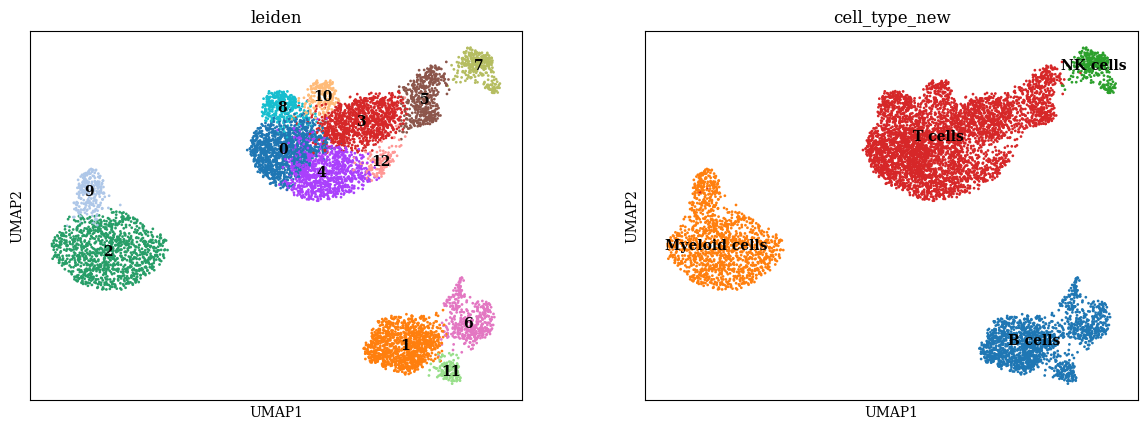

In [19]:
sc.pl.umap(
    adata_rna_donor_1,
    color=["leiden", "cell_type_new"],
    legend_loc="on data"
)

... storing 'cell_type_new' as categorical


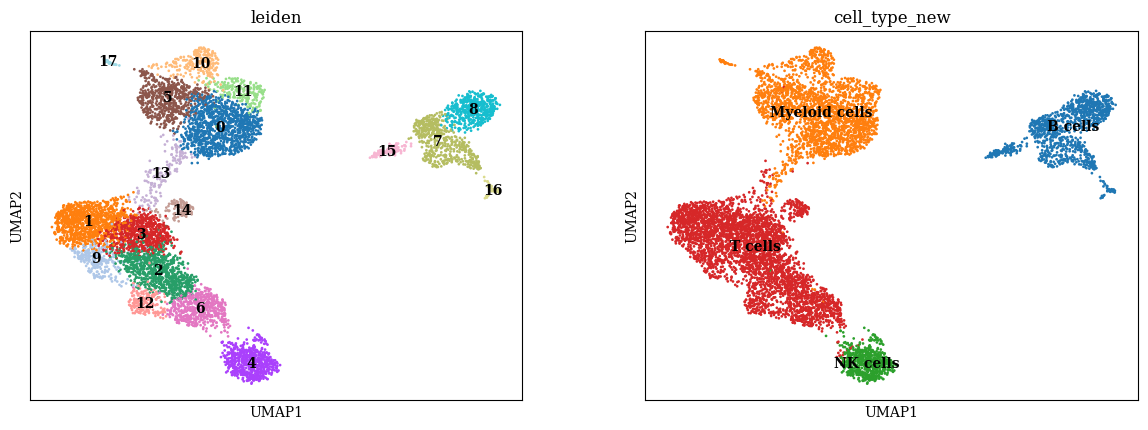

In [20]:
sc.pl.umap(
    adata_rna_donor_2,
    color=["leiden", "cell_type_new"],
    legend_loc="on data"
)

... storing 'cell_type_new' as categorical


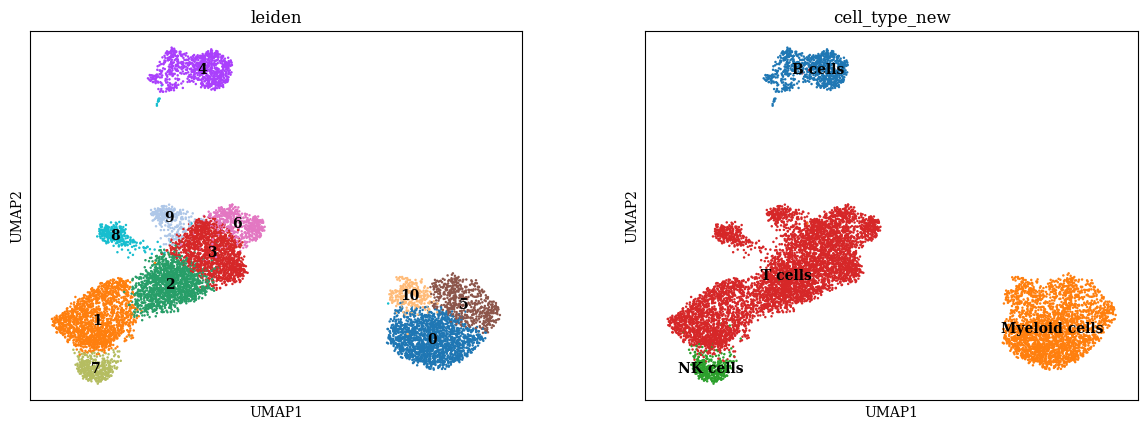

In [21]:
sc.pl.umap(
    adata_rna_donor_3,
    color=["leiden", "cell_type_new"],
    legend_loc="on data"
)

In [31]:
#TODO: cell type ratio per donor to check consistency 

adata_rna_new = ad.concat(adatas_all, axis=0)
adata_rna_new
del adata_rna_new.obsm
# del adata_rna_new.obs
adata_rna_new.obs['cell_type'] = adata_rna_new.obs['cell_type_new']
adata_rna_new.obs = adata_rna_new.obs.drop(columns=['cell_type_new', 'conf_score_celltypist_coarse','cell_type_celltypist_coarse', 'cell_type_original', 'Donor', 'Cell type', 'leiden'])
adata_rna_new.X = adata_rna_new.layers['counts']

adata_rna_new

AnnData object with n_obs × n_vars = 25034 × 22778
    obs: 'cell_type', 'donor_id'
    layers: 'counts'

In [33]:
func_leiden(adata_rna_new)

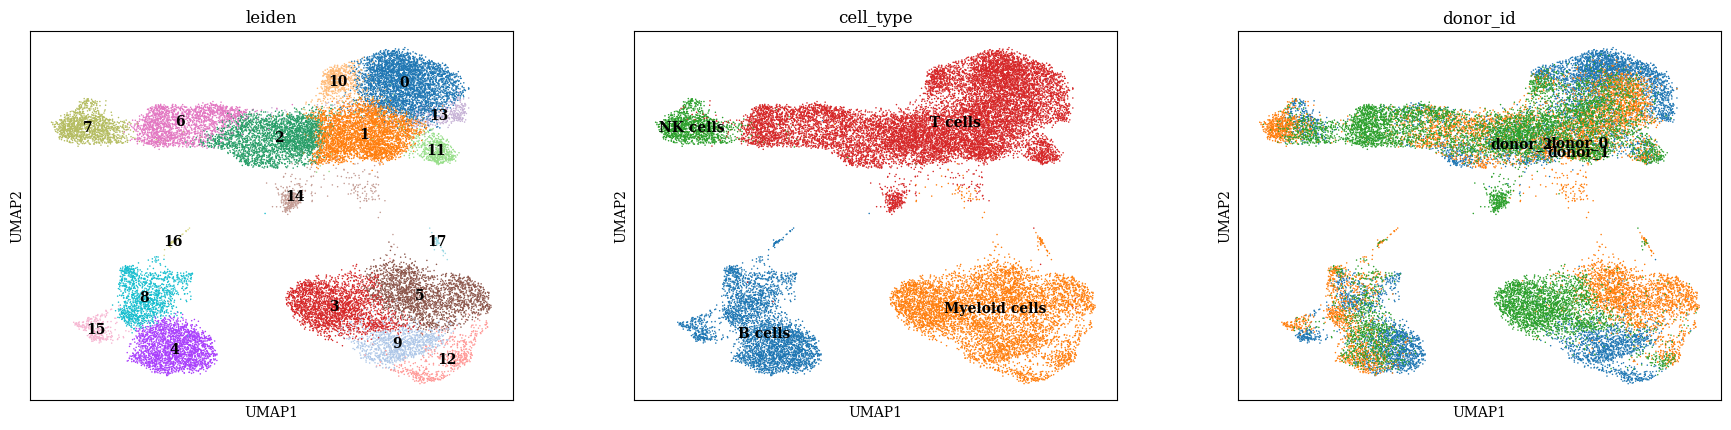

In [35]:
sc.pl.umap(
    adata_rna_new,
    color=["leiden", "cell_type", 'donor_id'],
    legend_loc="on data"
)

In [39]:
adata_rna_new

AnnData object with n_obs × n_vars = 25034 × 22778
    obs: 'cell_type', 'donor_id', 'leiden'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'cell_type_colors', 'donor_id_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [40]:
del adata_rna_new.obsm
del adata_rna_new.uns
del adata_rna_new.varm
del adata_rna_new.obsp
adata_rna_new.X = adata_rna_new.layers['counts']
del adata_rna_new.layers
# del adata_rna_new.obs
adata_rna_new.var = adata_rna_new.var[[]]
adata_rna_new.obs = adata_rna_new.obs[['cell_type', 'donor_id']]


In [41]:
adata_rna_new.write(f'{work_dir}/scRNA/adata_rna_new.h5ad')

(<Figure size 600x400 with 1 Axes>, <Axes: >)

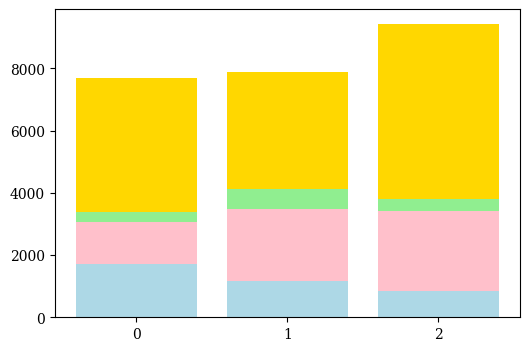

In [65]:
# consistency of cell type distributi
def plot_stacked_bar_chart(cell_types_in_drops, title='', xticks=None, 
                           xticklabels=None, colors=None, figsize=(25, 4), 
                           ax=None, legend=False, color_map=None):
    """
        Stacked bar plot to showcase the compound based distribution of cell counts. Adopted from AmbrosM. 
    """
    colors_cell_type = ['#ADD8E6', '#FFC0CB', '#90EE90', '#FFD700', '#E6E6FA', 'gray', 'red']
    # Add a column of zeros to the left and compute the cumulative sums
    cc = np.hstack([np.zeros((len(cell_types_in_drops), 1)), cell_types_in_drops])
    cc_cs = cc.cumsum(axis=1)
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = None
    cell_types = cell_types_in_drops.columns
    for i, cell_type in enumerate(cell_types):
        if color_map is None:
            color=colors_cell_type[i]
        else:
            color=color_map[cell_type]
        ax.bar(np.arange(len(cc_cs)),
               cc_cs[:,i+1] - cc_cs[:,i],
               bottom=cc_cs[:,i],
               label=cell_types[i], color=color)
         
    ax.set_title(title)
    if xticks is not None:
        ax.set_xticks(xticks)
    else:
        ax.set_xticks(np.arange(len(cc_cs)))
    if xticklabels is not None:
        ax.set_xticklabels(xticklabels, rotation=90)
    if colors is not None:
        for ticklabel, color in zip(ax.get_xticklabels(), colors):
            ticklabel.set_color(color)
    if legend: 
        ax.legend()
    color_legend_handles = [
        matplotlib.patches.Patch(facecolor='red', label='-'),
        matplotlib.patches.Patch(facecolor='blue', label='-'),
        matplotlib.patches.Patch(facecolor='green', label='-'),
    ]
    return fig, ax
cell_types_ratio = adata_rna_new.obs.groupby('donor_id').apply(lambda df:df.groupby('cell_type').size())

plot_stacked_bar_chart(cell_types_ratio, title='', xticks=None, 
                           xticklabels=None, colors=None, figsize=(6, 4), 
                           ax=None, legend=False, color_map=None)

In [ ]:
aa

# scATAC-seq

## Formatize the data

In [47]:
# extract only peaks
peaks_locations = multiome_var_meta[multiome_var_meta['feature_type']=='Peaks']['location'].values
df_peaks = multiome_train[multiome_train['location'].isin(peaks_locations)].reset_index(drop=True)
# del multiome_train

# make adata for each donor and save
def extract_count(count='count'):
    df_peaks_table = df_peaks.pivot_table(index='obs_id', columns='location', values=count)
    df_peaks_table.fillna(0, inplace=True)
    print('df_peaks table created')
    return df_peaks_table
df_peaks_table = extract_count(count='count')
# create adata
X = csr_matrix(df_peaks_table.values)
locations = df_peaks_table.columns
obs_ids = df_peaks_table.index
cell_types = []
for cell in obs_ids:
    cell_types.append(multiome_obs_meta[multiome_obs_meta['obs_id'] == cell].cell_type.values[0])




In [36]:
obs = pd.DataFrame(index=obs_ids)
obs['cell_type'] = cell_types
var = pd.DataFrame(index=locations)
adata_atac = ad.AnnData(X=X, obs=obs, var=var)
print('adata is created')

adata is created


In [37]:
split = adata_atac.var_names.str.split(r"[:-]")
adata_atac.var["chrom"] = split.map(lambda x: x[0]).astype(str)
adata_atac.var["chromStart"] = split.map(lambda x: x[1]).astype(int)
adata_atac.var["chromEnd"] = split.map(lambda x: x[2]).astype(int)
adata_atac.var.head()

,chrom,chromStart,chromEnd
location,,,
GL000194.1:100992-101876,GL000194.1,100992,101876
GL000194.1:104344-105163,GL000194.1,104344,105163
GL000194.1:110741-111545,GL000194.1,110741,111545
GL000194.1:114513-115368,GL000194.1,114513,115368
GL000194.1:27939-28826,GL000194.1,27939,28826


In [38]:
mask_standard_dna = adata_atac.var['chrom'].str.match(r'^chr(?:\d+|X|Y)$')
adata_atac = adata_atac[:,mask_standard_dna]

In [39]:
# add donor info
adata_atac.obs = pd.merge(adata_atac.obs, multiome_obs_meta[['obs_id', 'donor_id']], on='obs_id', how='left')


In [43]:
# save
adata_atac.write(f'{work_dir}/scATAC/adata_atac.h5ad')

## UMAP plot using scATAC-seq


In [50]:
adata_atac = ad.read_h5ad(f'{work_dir}/scATAC/adata_atac.h5ad')

In [51]:
adata_atac.layers['counts'] = adata_atac.X.copy()

In [52]:
# import warnings
warnings.simplefilter("ignore")
with warnings.catch_warnings():
    sc.pp.normalize_total(adata_atac)
    sc.pp.log1p(adata_atac)
    sc.pp.highly_variable_genes(adata_atac, n_top_genes=3000)
    sc.tl.pca(adata_atac, svd_solver='arpack', use_highly_variable=True)
    sc.pp.neighbors(adata_atac, n_neighbors=10, n_pcs=50)
    sc.tl.umap(adata_atac)
adata_atac

AnnData object with n_obs × n_vars = 25034 × 135358
    obs: 'cell_type', 'donor_id'
    var: 'chrom', 'chromStart', 'chromEnd', 'feature_type', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

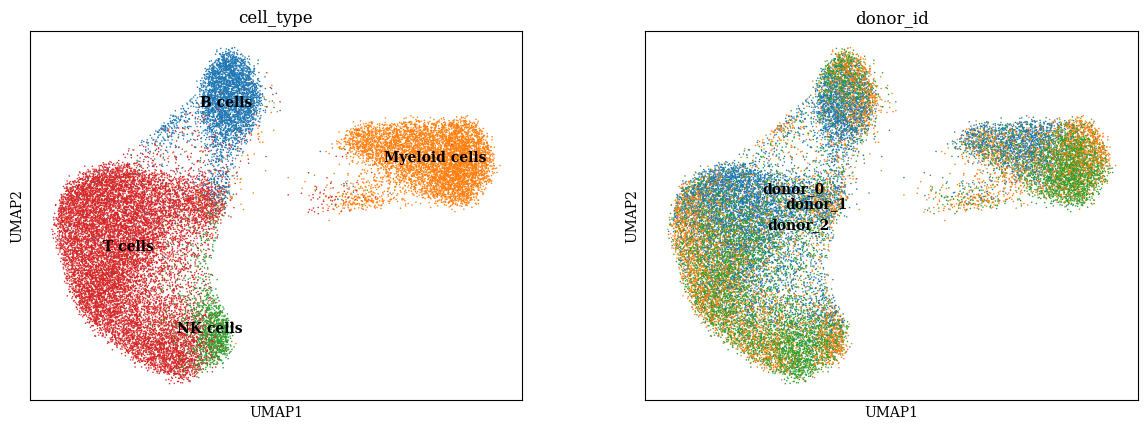

In [53]:
sc.pl.umap(
    adata_atac,
    color=["cell_type", 'donor_id'],
    legend_loc="on data"
)